In [1]:
#%matplotlib qt
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid')
import scipy
from scipy import special as s
import numpy
import math
import time

from mpl_toolkits.mplot3d import Axes3D

In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import two_layer_net

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/velocity')

In [7]:
def phi(alpha, theta, mean=0, scale=1):
    x = alpha / np.tan(theta)  # cotant(theta) = 1 / tan(theta)
    return scipy.stats.norm.cdf(x, loc=mean, scale=scale)

In [8]:
def phi_tilde(alpha, theta, mean=0, scale=1):
    # the odd part of phi is simply phi - 1/2 as for the step function
    x = alpha / np.tan(theta)  # cotant(theta) = 1 / tan(theta)
    return scipy.stats.norm.cdf(x, loc=mean, scale=scale) - 1/2

In [9]:
def psi(alpha, theta):
    # psi is symmetric, psi=scipy.stats.norm.pdf(-alpha * cotan(theta))
    x = alpha / np.tan(theta)  # cotant(theta) = 1 / tan(theta)
    return np.exp(-(x ** 2) / 2) / np.sqrt(2 * np.pi)

In [10]:
def q(alpha, theta, mean=0, scale=1, sign=True):
    # phi is assumed to be odd
    # if sign:
    #    eps_theta = np.sign(np.pi/2 - theta)
    #else:
    #    eps_theta = 1
#    return eps * (np.sin(theta) * alpha * phi(alpha, theta, mean=mean, scale=scale) - 
#                  np.cos(theta) * psi(alpha, theta))
#    return eps_theta * (np.sin(theta) * alpha * phi_tilde(alpha, theta, mean=mean, scale=scale) - 
#                        np.cos(theta) * psi(alpha, theta))
    return np.sin(theta) * alpha * phi_tilde(alpha, theta, mean=mean, scale=scale) - \
           np.cos(theta) * psi(alpha, theta)

In [11]:
def q_tilde(alpha, theta, mean=0, scale=1, sign=True, d_H=1, max_r=10):
    return scipy.integrate.quad(
        lambda r: (r ** d_H) * q(r * alpha, theta, mean=mean, scale=scale, sign=sign) * \
                  np.exp(-(r ** 2)/2), a=0, b=max_r)[0]

In [12]:
def legendre(k, d, t):
    max_j = math.floor(k/2)
    sum_j = np.sum(
        [((-1) ** j) * ((1 - (t**2)) ** j) * (t ** (k-2*j)) / \
         ((4 ** j) * s.factorial(j) * s.factorial(k - 2*j) * s.gamma(j + (d-1)/2)) \
         for j in range(max_j + 1)])
    return s.factorial(k) * s.gamma((d-1)/2) * sum_j

In [13]:
def lambda_2(k, theta, mean=0, scale=1, sign=True, d_H=1):
    return scipy.integrate.dblquad(
        lambda t,r: (r ** d_H) * q(r * t, theta, mean=mean, scale=scale, sign=sign) * np.exp(-(r ** 2)/2) * \
                    (1 - (t ** 2)) ** ((d_H - 3) / 2) * \
                    legendre(k, d_H, t),
        a=0,
        b=10, 
        gfun=lambda z: -1,
        hfun=lambda z: 1)[0]

In [14]:
start = time.time()
d_H = 2
k = 2
thetas = [1e-5, np.pi/4, np.pi/3, 2*np.pi/2, 3*np.pi/4, np.pi/2 - 1e-5]
l = [lambda_2(k, theta, d_H=d_H) for theta in thetas]
end = time.time()
print('Took {:.3f} minutes'.format((end - start) / 60))
l

/Users/karlhajjar/Documents/projects/learning-structure/env/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Took 0.511 minutes


[6.666552033100552e-06,
 0.6527947345878303,
 0.5339999256266633,
 -7.601491680830495e-17,
 -0.6527947345878352,
 1.1780731218135321e-05]

/Users/karlhajjar/Documents/projects/learning-structure/env/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Took 43.997 minutes


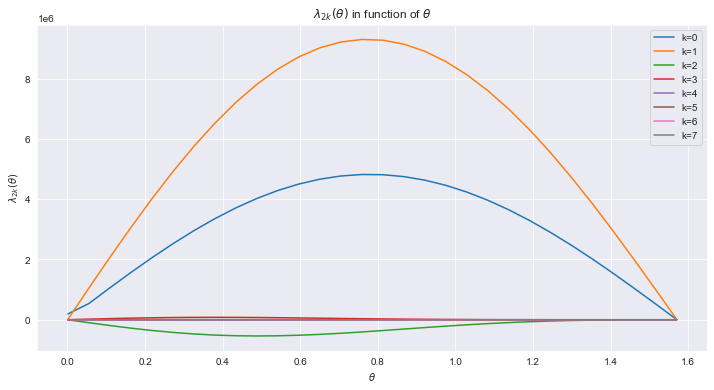

In [28]:
start = 1e-3
stop = np.pi/2 - 1e-3
num = 30
K = 7
d_H = 20
ks = np.arange(0, 2*K+1, step=2)

thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
start = time.time()
ys = [[lambda_2(k, theta, d_H=d_H) for theta in thetas] for k in ks]
end = time.time()
print('Took {:.3f} minutes'.format((end - start) / 60))

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, k in enumerate(ks):
    plt.plot(thetas, ys[i], label='k={:,}'.format(i))

plt.title('$\lambda_{2k}(\\theta)$ in function of $\\theta$')
plt.xlabel('$\\theta$')
plt.ylabel('$\lambda_{2k}(\\theta)$')
plt.legend()
plt.show()

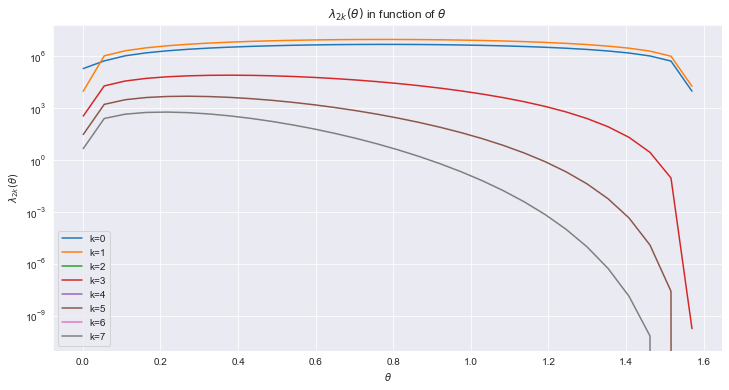

In [37]:
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, k in enumerate(ks):
    plt.plot(thetas, ys[i], label='k={:,}'.format(i))
    plt.yscale('log')

plt.title('$\lambda_{2k}(\\theta)$ in function of $\\theta$')
plt.xlabel('$\\theta$')
plt.ylabel('$\lambda_{2k}(\\theta)$')
plt.legend()
plt.show()

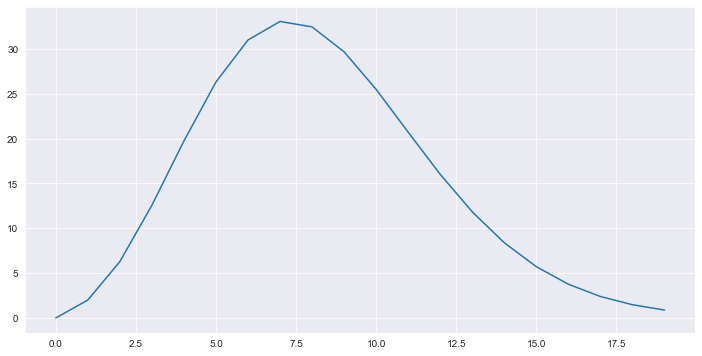

In [35]:
figsize = (12, 6)
dims = np.arange(20)
areas = [2 * np.pi ** ((dim)/2) / s.gamma((dim)/2) for dim in dims]
plt.figure(figsize=figsize)
plt.plot(dims, areas)
plt.show()

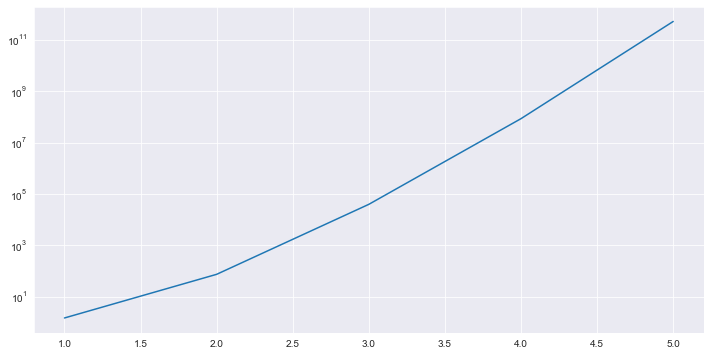

In [47]:
figsize = (12, 6)
dim = 5
ks = np.arange(1, 6)
ys = [s.factorial(2*k -2) * s.binom(2*k + (dim-3)/2, k-1) / (4**k) * s.gamma(2*k + (dim-1)/2)
      for k in ks]
plt.figure(figsize=figsize)
plt.plot(ks, ys)
plt.yscale('log')
plt.show()

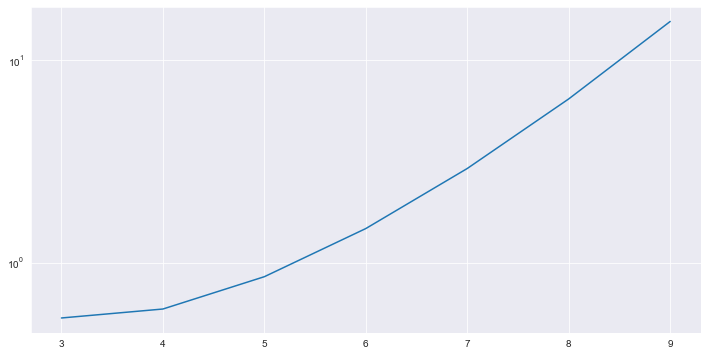

In [49]:
figsize = (12, 6)
dims = np.arange(3, 10)
ys = [((2 ** (dim/2 -2)) / np.sqrt(np.pi)) * \
      ((dim-1)/dim) * \
      ((s.gamma(1/2) * ((s.gamma((dim-1)/2)) ** 2)) / s.gamma(dim/2))
      for dim in dims]
plt.figure(figsize=figsize)
plt.plot(dims, ys)
plt.yscale('log')
plt.show()

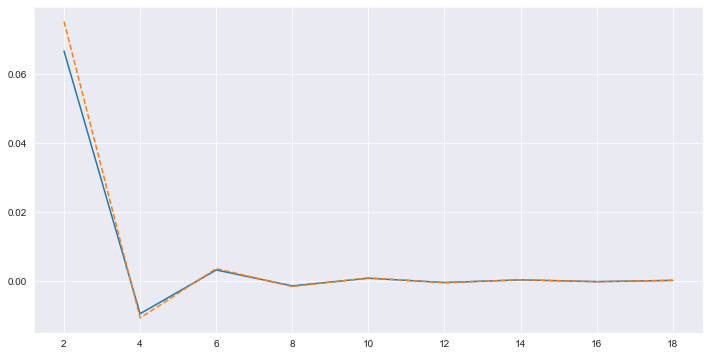

In [69]:
figsize = (12, 6)
dim = 4
ks = np.arange(1, 10)
ys_1 = [scipy.integrate.quad(lambda t: legendre(2*k, dim, t) * t * (1 - (t ** 2)) ** ((dim - 3) / 2),
                           a=0, b=1)[0]
      for k in ks]
ys_2 = [((-1) ** (k-1)) * s.factorial(2 * k - 2) / ((4 ** k) * s.factorial(k-1) * s.gamma(k + (dim+1)/2)) * \
        s.gamma((dim-2)/2)
      for k in ks]
plt.figure(figsize=figsize)
plt.plot([2*k for k in ks], ys_1)
plt.plot([2*k for k in ks], ys_2, linestyle='dashed')
plt.show()

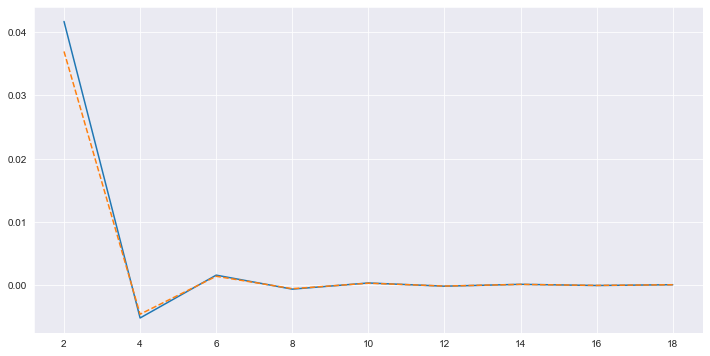

In [70]:
figsize = (12, 6)
dim = 5
ks = np.arange(1, 10)
ys_1 = [scipy.integrate.quad(lambda t: legendre(2*k, dim, t) * t * (1 - (t ** 2)) ** ((dim - 3) / 2),
                           a=0, b=1)[0]
      for k in ks]
ys_2 = [((-1) ** (k-1)) * s.factorial(2 * k - 2) / ((4 ** k) * s.factorial(k-1) * s.gamma(k + (dim+1)/2)) * \
        s.gamma((dim-2)/2)
      for k in ks]
plt.figure(figsize=figsize)
plt.plot([2*k for k in ks], ys_1)
plt.plot([2*k for k in ks], ys_2, linestyle='dashed')
plt.show()

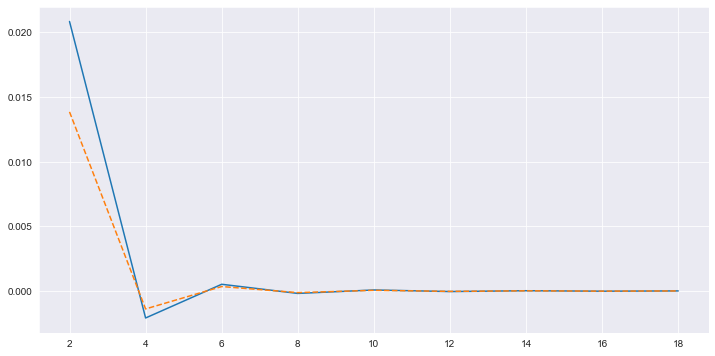

In [71]:
figsize = (12, 6)
dim = 7
ks = np.arange(1, 10)
ys_1 = [scipy.integrate.quad(lambda t: legendre(2*k, dim, t) * t * (1 - (t ** 2)) ** ((dim - 3) / 2),
                           a=0, b=1)[0]
      for k in ks]
ys_2 = [((-1) ** (k-1)) * s.factorial(2 * k - 2) / ((4 ** k) * s.factorial(k-1) * s.gamma(k + (dim+1)/2)) * \
        s.gamma((dim-2)/2)
      for k in ks]
plt.figure(figsize=figsize)
plt.plot([2*k for k in ks], ys_1)
plt.plot([2*k for k in ks], ys_2, linestyle='dashed')
plt.show()

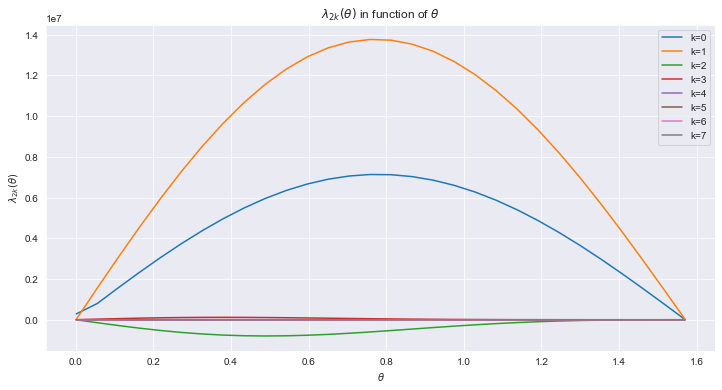

In [30]:
norm_factor = 2 * (np.pi ** ((d_H - 2)/2)) / s.gamma((d_H-2)/2)
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, k in enumerate(ks):
    plt.plot(thetas, norm_factor * np.array(ys[i]), label='k={:,}'.format(i))
    #plt.yscale('log')

plt.title('$\lambda_{2k}(\\theta)$ in function of $\\theta$')
plt.xlabel('$\\theta$')
plt.ylabel('$\lambda_{2k}(\\theta)$')
plt.legend()
plt.show()

In [22]:
[np.sqrt((np.log(2) + 1 * np.log(10)) / dim) for dim in np.arange(1, 100, step=10)]

[1.7308183826022854,
 0.5218613777583252,
 0.37769553583314336,
 0.3108641583607775,
 0.2703084179569516,
 0.2423630510227552,
 0.22160858543889803,
 0.20541035101371435,
 0.19231315362247617,
 0.18143906656015316]

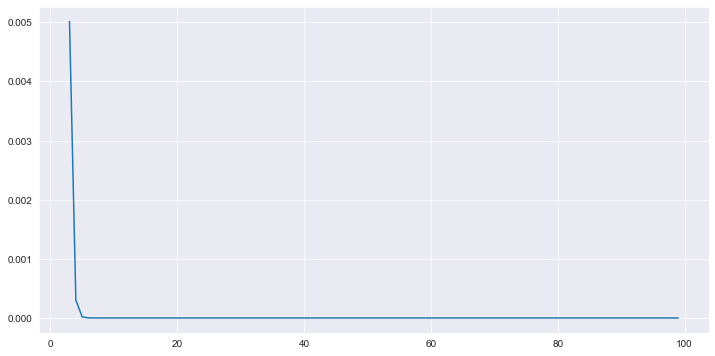

In [27]:
figsize = (12, 6)
dims = np.arange(3, 100)
eps=1e-1

ys = [4 * s.gamma(dim/2) * (1 - np.sqrt(1 - (eps ** 2))) ** ((dim - 1) / 2) / \
      (np.sqrt(np.pi) * s.gamma((dim - 1)/2) * (dim - 1))
      for dim in dims]
plt.figure(figsize=figsize)
plt.plot(dims, ys)
plt.show()

/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_51369/353458701.py:5: RuntimeWarning: invalid value encountered in double_scalars
  ys = [s.gamma(dim/2) / (s.gamma((dim - 1)/2)) for dim in dims]


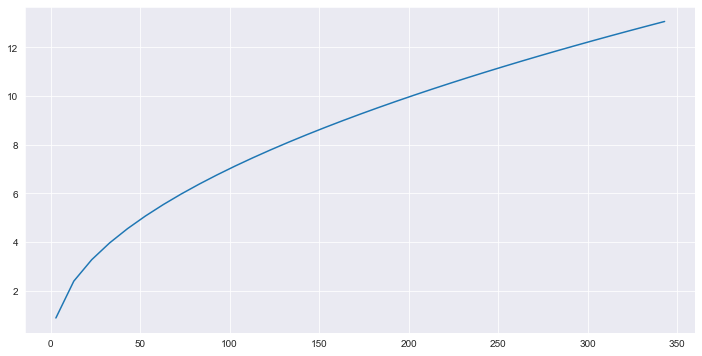

In [31]:
figsize = (12, 6)
dims = np.arange(3, 1e5, step=10)
eps=1e-1

ys = [s.gamma(dim/2) / (s.gamma((dim - 1)/2)) for dim in dims]
plt.figure(figsize=figsize)
plt.plot(dims, ys)
plt.show()

/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_51369/2501719108.py:5: RuntimeWarning: overflow encountered in double_scalars
  ys = [s.gamma(dim/2) / (s.gamma((dim - 1)/2) * (dim-1)) for dim in dims]
/var/folders/dk/nmyl016j3lj9xqhfs1wy5fgr0000gn/T/ipykernel_51369/2501719108.py:5: RuntimeWarning: invalid value encountered in double_scalars
  ys = [s.gamma(dim/2) / (s.gamma((dim - 1)/2) * (dim-1)) for dim in dims]


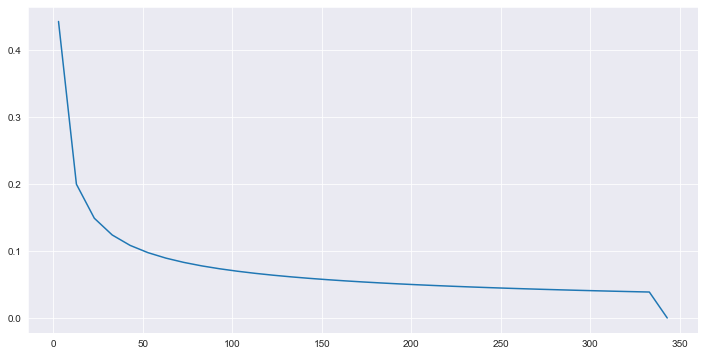

In [32]:
figsize = (12, 6)
dims = np.arange(3, 1e5, step=10)
eps=1e-1

ys = [s.gamma(dim/2) / (s.gamma((dim - 1)/2) * (dim-1)) for dim in dims]
plt.figure(figsize=figsize)
plt.plot(dims, ys)
plt.show()

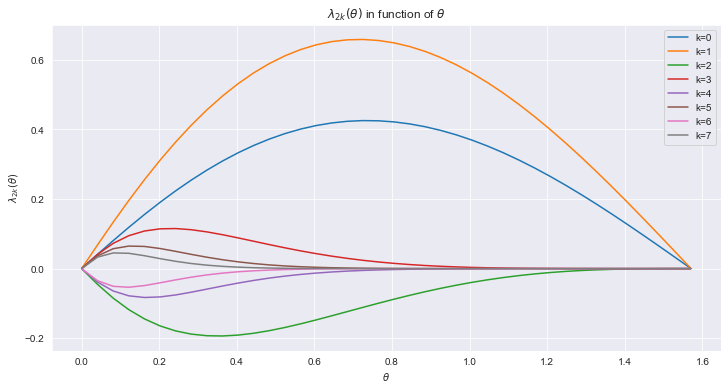

In [152]:
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, k in enumerate(ks):
    plt.plot(thetas, ys[i], label='k={:,}'.format(i))

plt.title('$\lambda_{2k}(\\theta)$ in function of $\\theta$')
plt.xlabel('$\\theta$')
plt.ylabel('$\lambda_{2k}(\\theta)$')
plt.legend()
plt.show()

In [12]:
def velocity_1d(theta, u, f_H):
    return scipy.integrate.quad(
        lambda x_H: f_H(x_H) * q(u * x_H, theta) * np.exp(- (x_H ** 2) / 2) / np.sqrt(2 * np.pi),
        a=-np.inf,
        b=np.inf)[0]

In [14]:
def velocity_2d(theta, phi, f_H):
    return scipy.integrate.dblquad(
        lambda y,x: f_H(x,y) * q(np.cos(phi) * x + np.sin(phi) * y, theta) * np.exp(-(x**2 + y**2)/2) / (2*np.pi),
        a=-np.inf,
        b=np.inf, 
        gfun=-np.inf,
        hfun=np.inf
    )[0]

In [ ]:
import time
num = 20

start = time.time()
thetas = np.linspace(1e-6, np.pi/2, num=num)
[velocity_2d(theta, 0, f_H) for theta in thetas]
end = time.time()
print('Time spent on {:,} values : {:.3f} seconds'.format(num, end - start))

In [38]:
def S(dim):
    return 2 * (np.pi) ** (dim/2) / s.gamma(dim/2)

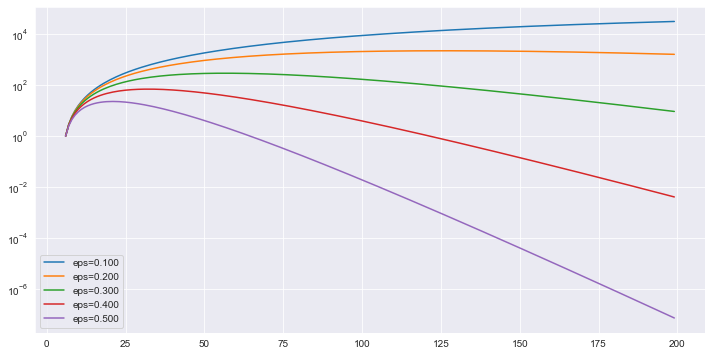

In [136]:
eps_ = [0.1, 0.2, 0.3, 0.4, 0.5]
d_H = 5
dims = np.arange(d_H+1, 200)
ys = [[S(dim-d_H) * S(d_H+1) * ((1 - (eps**2)) ** ((dim - d_H - 1)/2)) / (2*S(dim))
       for dim in dims] for eps in eps_]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='eps={:.3f}'.format(eps_[i]))
    plt.yscale('log')
plt.legend()
plt.show()

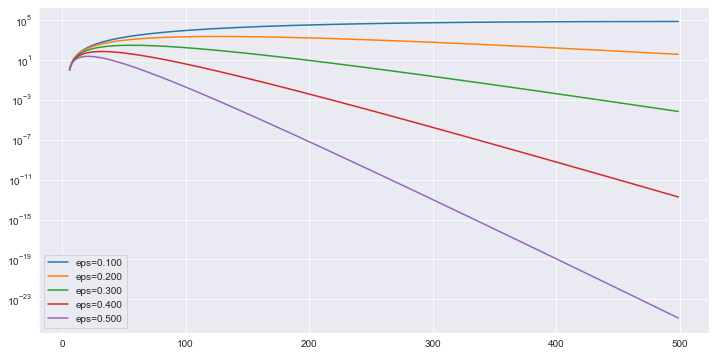

In [139]:
eps_ = [0.1, 0.2, 0.3, 0.4, 0.5]
d_H = 5
dims = np.arange(d_H+1, 100*d_H)
ys = [[np.sqrt(np.pi) * s.gamma(d_H/2) / (s.beta(d_H/2, (dim-d_H)/2) * s.gamma((d_H+1)/2)) * \
       ((1 - (eps**2)) ** ((dim - d_H - 1)/2))
       for dim in dims] for eps in eps_]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='eps={:.3f}'.format(eps_[i]))
    plt.yscale('log')
plt.legend()
plt.show()

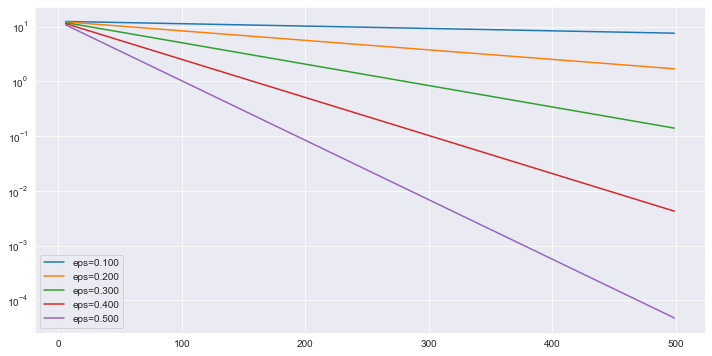

In [185]:
eps_ = [0.1, 0.2, 0.3, 0.4, 0.5]
d_H = 5
dims = np.arange(d_H+1, 100*d_H)
ys = [[np.sqrt(2 * np.pi) * d_H * np.exp(- dim *  (eps ** 2) / (2 * d_H))
       for dim in dims] for eps in eps_]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='eps={:.3f}'.format(eps_[i]))
    plt.yscale('log')
plt.legend()
plt.show()

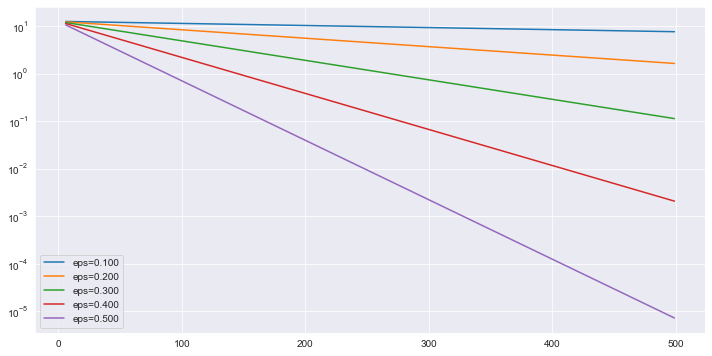

In [188]:
eps_ = [0.1, 0.2, 0.3, 0.4, 0.5]
d_H = 5
dims = np.arange(d_H+1, 100*d_H)
ys = [[np.sqrt(2 * np.pi) * d_H * (1 - (eps**2)) ** (dim/(2*d_H))
       for dim in dims] for eps in eps_]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='eps={:.3f}'.format(eps_[i]))
    plt.yscale('log')
plt.legend()
plt.show()

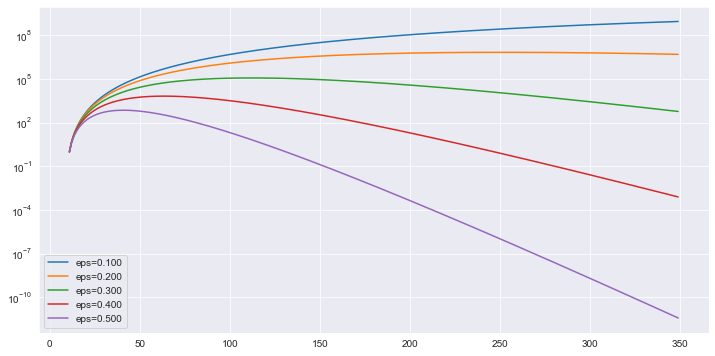

In [141]:
eps_ = [0.1, 0.2, 0.3, 0.4, 0.5]
d_H = 10
dims = np.arange(d_H+1, 35*d_H)
ys = [[np.sqrt(np.pi) * s.gamma(d_H/2) / (s.beta(d_H/2, (dim-d_H)/2) * s.gamma((d_H+1)/2)) * \
       ((1 - (eps**2)) ** ((dim - d_H - 1)/2))
       for dim in dims] for eps in eps_]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='eps={:.3f}'.format(eps_[i]))
    plt.yscale('log')
plt.legend()
plt.show()

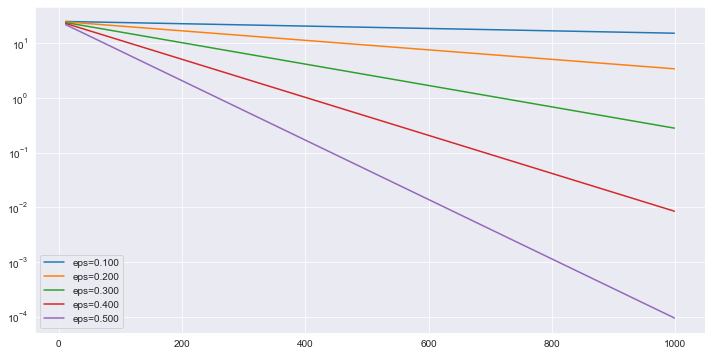

In [186]:
eps_ = [0.1, 0.2, 0.3, 0.4, 0.5]
d_H = 10
dims = np.arange(d_H+1, 100*d_H)
ys = [[np.sqrt(2 * np.pi) * d_H * np.exp(- dim *  (eps ** 2) / (2 * d_H))
       for dim in dims] for eps in eps_]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='eps={:.3f}'.format(eps_[i]))
    plt.yscale('log')
plt.legend()
plt.show()

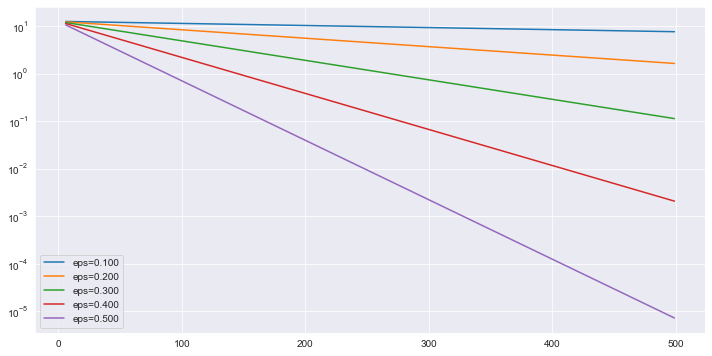

In [189]:
eps_ = [0.1, 0.2, 0.3, 0.4, 0.5]
d_H = 5
dims = np.arange(d_H+1, 100*d_H)
ys = [[np.sqrt(2 * np.pi) * d_H * (1 - (eps**2)) ** (dim/(2*d_H))
       for dim in dims] for eps in eps_]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='eps={:.3f}'.format(eps_[i]))
    plt.yscale('log')
plt.legend()
plt.show()

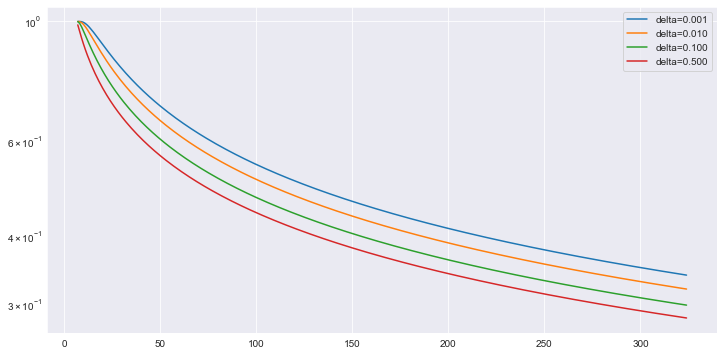

In [142]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_H = 5
dims = np.arange(d_H+2, 65*d_H)
ys = [[(1 - (delta * s.beta(d_H/2, (dim -d_H)/2) * s.gamma((d_H+1)/2) / \
        (np.sqrt(np.pi) * s.gamma(d_H/2))) ** (2/(dim - d_H -1))) ** (1/2)
       for dim in dims] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='delta={:.3f}'.format(deltas[i]))
    plt.yscale('log')
plt.legend()
plt.show()

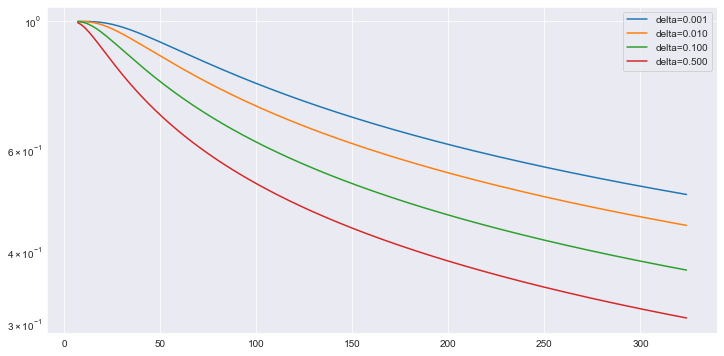

In [190]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_H = 5
dims = np.arange(d_H+2, 65*d_H)
ys = [[(1 - (delta / (d_H * np.sqrt(2*np.pi))) ** (2*d_H/dim)) ** (1/2)
       for dim in dims] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='delta={:.3f}'.format(deltas[i]))
    plt.yscale('log')
plt.legend()
plt.show()

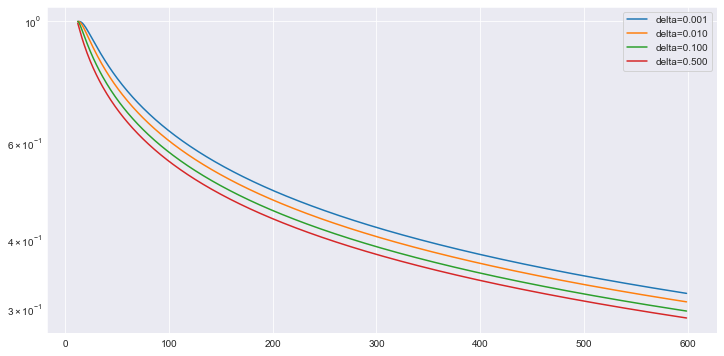

In [143]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_H = 10
dims = np.arange(d_H+2, 60*d_H)
ys = [[(1 - (delta * s.beta(d_H/2, (dim -d_H)/2) * s.gamma((d_H+1)/2) / \
        (np.sqrt(np.pi) * s.gamma(d_H/2))) ** (2/(dim - d_H -1))) ** (1/2)
       for dim in dims] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='delta={:.3f}'.format(deltas[i]))
    plt.yscale('log')
plt.legend()
plt.show()

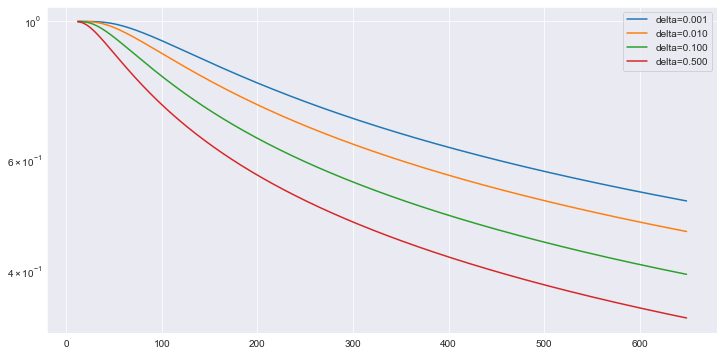

In [191]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_H = 10
dims = np.arange(d_H+2, 65*d_H)
ys = [[(1 - (delta / (d_H * np.sqrt(2*np.pi))) ** (2*d_H/dim)) ** (1/2)
       for dim in dims] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='delta={:.3f}'.format(deltas[i]))
    plt.yscale('log')
plt.legend()
plt.show()

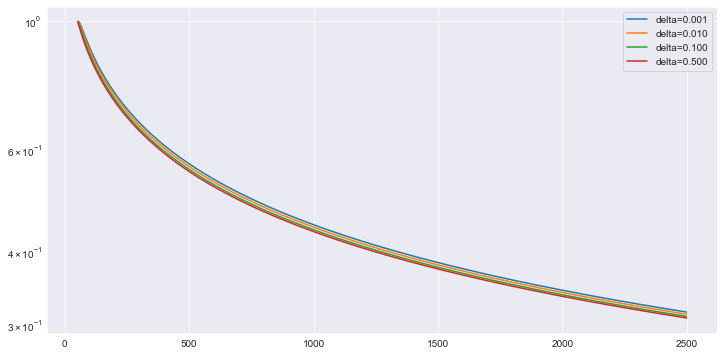

In [144]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_H = 50
dims = np.arange(d_H+2, 50*d_H)
ys = [[(1 - (delta * s.beta(d_H/2, (dim -d_H)/2) * s.gamma((d_H+1)/2) / \
        (np.sqrt(np.pi) * s.gamma(d_H/2))) ** (2/(dim - d_H -1))) ** (1/2)
       for dim in dims] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='delta={:.3f}'.format(deltas[i]))
    plt.yscale('log')
plt.legend()
plt.show()

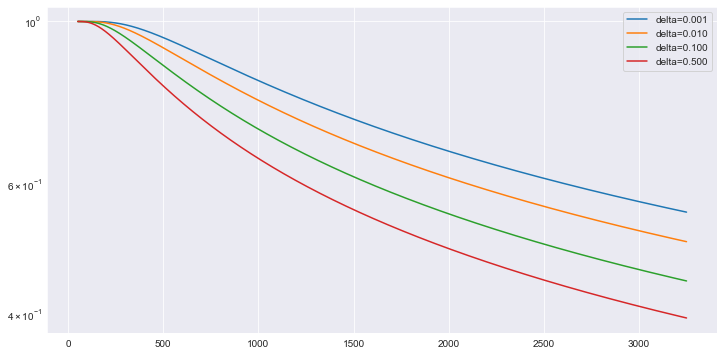

In [193]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_H = 50
dims = np.arange(d_H+2, 65*d_H)
ys = [[(1 - (delta / (d_H * np.sqrt(2*np.pi))) ** (2*d_H/dim)) ** (1/2)
       for dim in dims] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='delta={:.3f}'.format(deltas[i]))
    plt.yscale('log')
plt.legend()
plt.show()

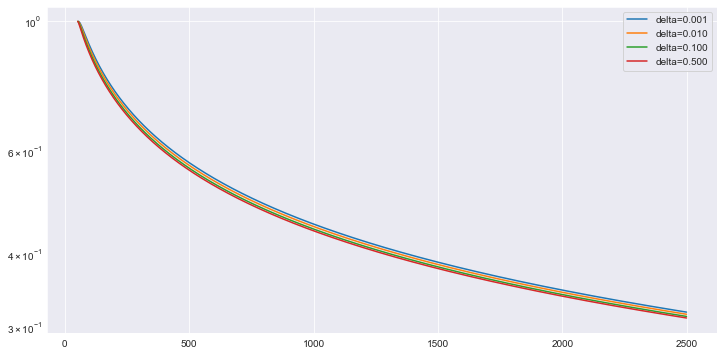

In [118]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_H = 50
dims = np.arange(d_H+2, 50*d_H)
ys = [[(1 - (delta/2 * s.beta(d_H/2, (dim - d_H)/2)) ** (2/(dim - d_H -1))) ** (1/2)
       for dim in dims] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(dims, y, label='delta={:.3f}'.format(deltas[i]))
    plt.yscale('log')
plt.legend()
plt.show()

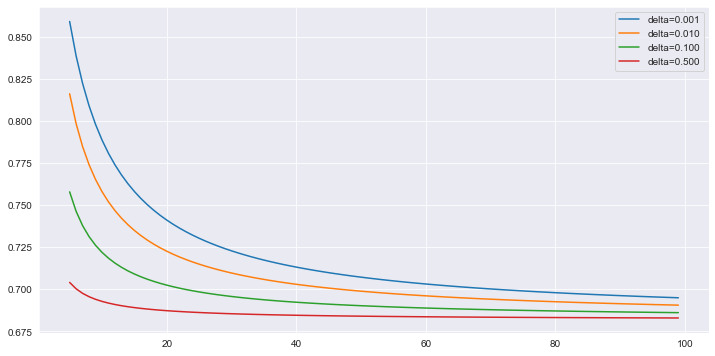

In [154]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_Hs = np.arange(5, 100)
scale = 5  # d = scale * d_H
ys = [[(1 - (delta * s.beta(d_H/2, (scale-1)*d_H/2) * s.gamma((d_H+1)/2) / \
        (np.sqrt(np.pi) * s.gamma(d_H/2))) ** (2/((scale-1)*d_H -1))) ** (1/2)
       for d_H in d_Hs] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(d_Hs, y, label='delta={:.3f}'.format(deltas[i]))
plt.legend()
plt.show()

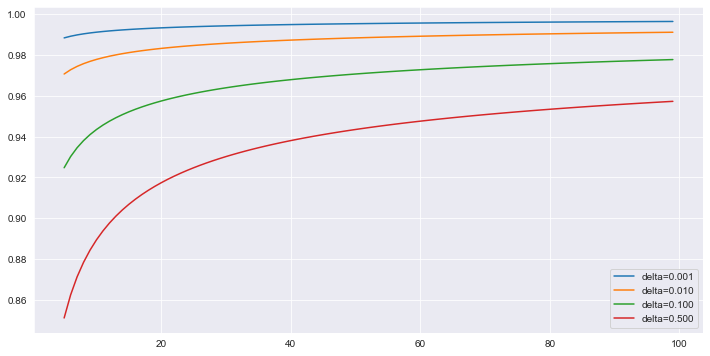

In [194]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_Hs = np.arange(5, 100)
scale = 5  # d = scale * d_H
ys = [[(1 - (delta / (d_H * np.sqrt(2*np.pi))) ** (2/scale)) ** (1/2)
       for d_H in d_Hs] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(d_Hs, y, label='delta={:.3f}'.format(deltas[i]))
plt.legend()
plt.show()

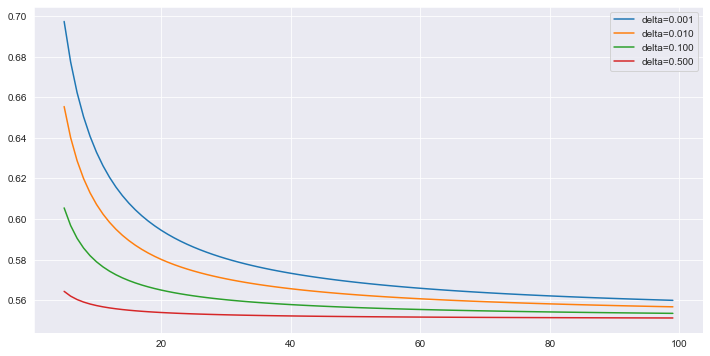

In [162]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_Hs = np.arange(5, 100)
scale = 10  # d = scale * d_H
ys = [[(1 - (delta * s.beta(d_H/2, (scale-1)*d_H/2) * s.gamma((d_H+1)/2) / \
        (np.sqrt(np.pi) * s.gamma(d_H/2))) ** (2/((scale-1)*d_H -1))) ** (1/2)
       for d_H in d_Hs] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(d_Hs, y, label='delta={:.3f}'.format(deltas[i]))
plt.legend()
plt.show()

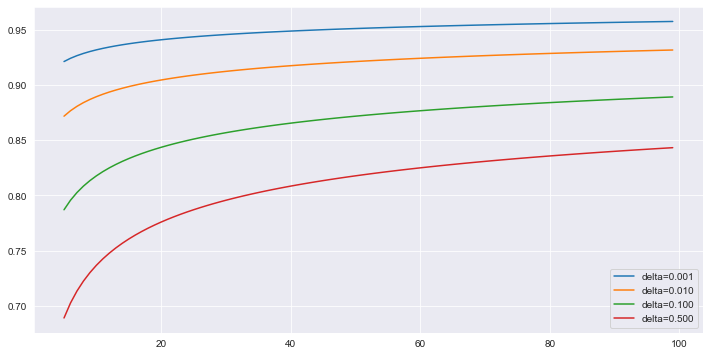

In [196]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_Hs = np.arange(5, 100)
scale = 10  # d = scale * d_H
ys = [[(1 - (delta / (d_H * np.sqrt(2*np.pi))) ** (2/scale)) ** (1/2)
       for d_H in d_Hs] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(d_Hs, y, label='delta={:.3f}'.format(deltas[i]))
plt.legend()
plt.show()

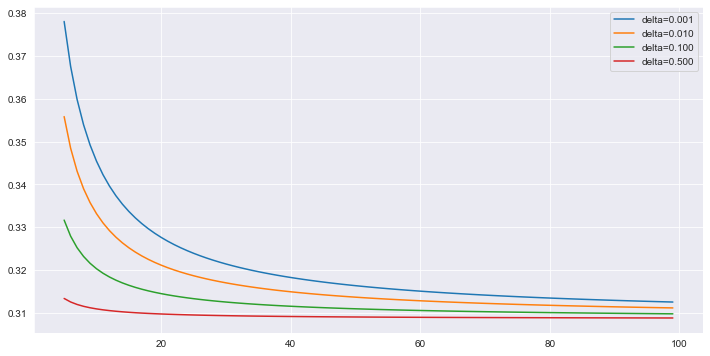

In [164]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_Hs = np.arange(5, 100)
scale = 50  # d = scale * d_H
ys = [[(1 - (delta * s.beta(d_H/2, (scale-1)*d_H/2) * s.gamma((d_H+1)/2) / \
        (np.sqrt(np.pi) * s.gamma(d_H/2))) ** (2/((scale-1)*d_H -1))) ** (1/2)
       for d_H in d_Hs] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(d_Hs, y, label='delta={:.3f}'.format(deltas[i]))
plt.legend()
plt.show()

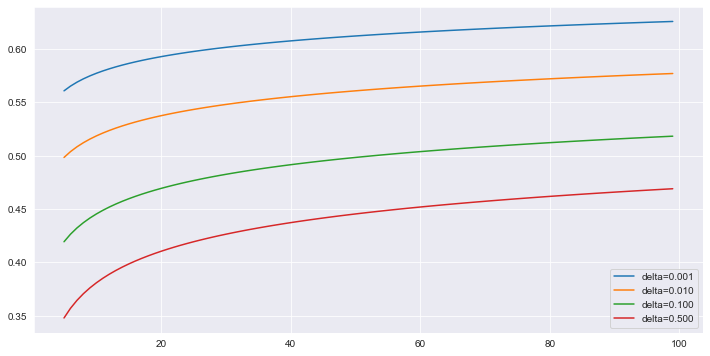

In [197]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_Hs = np.arange(5, 100)
scale = 50  # d = scale * d_H
ys = [[(1 - (delta / (d_H * np.sqrt(2*np.pi))) ** (2/scale)) ** (1/2)
       for d_H in d_Hs] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(d_Hs, y, label='delta={:.3f}'.format(deltas[i]))
plt.legend()
plt.show()

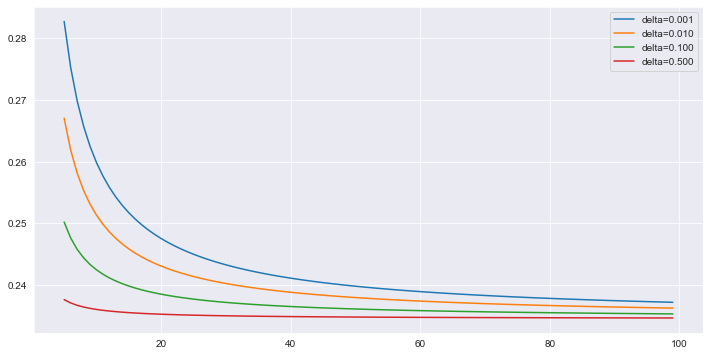

In [176]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_Hs = np.arange(5, 100)
scale = 100  # d = scale * d_H
ys = [[(1 - (delta * s.beta(d_H/2, (scale-1)*d_H/2) * s.gamma((d_H+1)/2) / \
        (np.sqrt(np.pi) * s.gamma(d_H/2))) ** (2/((scale-1)*d_H -1))) ** (1/2)
       for d_H in d_Hs] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(d_Hs, y, label='delta={:.3f}'.format(deltas[i]))
plt.legend()
plt.show()

In [200]:
np.log(3)

1.0986122886681098

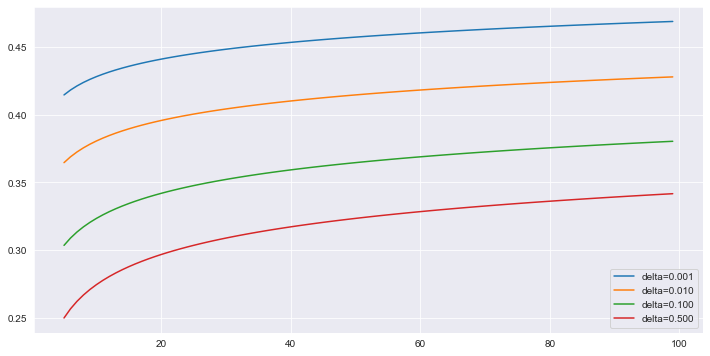

In [198]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_Hs = np.arange(5, 100)
scale = 100  # d = scale * d_H
ys = [[(1 - (delta / (d_H * np.sqrt(2*np.pi))) ** (2/scale)) ** (1/2)
       for d_H in d_Hs] for delta in deltas]
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, y in enumerate(ys):
    plt.plot(d_Hs, y, label='delta={:.3f}'.format(deltas[i]))
plt.legend()
plt.show()

In [177]:
d_Hs[5]

10

In [178]:
ys[2][5]

0.24246180885596205

In [179]:
np.arccos(0.24246180885596205) / (np.pi/2)

0.8440901778952976

In [180]:
ys[1][5]

0.25131691698769976

In [181]:
np.arccos(0.25131691698769976) / (np.pi/2)

0.8382727307492345

In [182]:
np.arccos(ys[2][15]) / (np.pi/2)

0.8466788139339768

In [183]:
np.arccos(ys[1][15]) / (np.pi/2)

0.8436931705394103

In [149]:
def theta_min(scale, d_H, delta):
    # d = scale * d_H
    eps_min = (1 - (delta * s.beta(d_H/2, (scale-1)*d_H/2) * s.gamma((d_H+1)/2) / \
               (np.sqrt(np.pi) * s.gamma(d_H/2))) ** (2/((scale-1)*d_H -1))) ** (1/2)
    print('eps_min = {:.4f}'.format(eps_min))
    theta_min = np.arccos(eps_min)
    print('theta_min = {:.4f}'.format(theta_min))
    return theta_min / (np.pi/2)

In [159]:
theta_min(10, 10, 0.1)

eps_min = 0.7220
theta_min = 0.7642


0.48648754611136946

In [161]:
theta_min(10, 10, 0.3)

eps_min = 0.5644
theta_min = 0.9711


0.6182153867399365

In [128]:
np.arccos(0.25)

1.318116071652818

In [129]:
1.318116071652818 / (np.pi/2)

0.8391387534896676

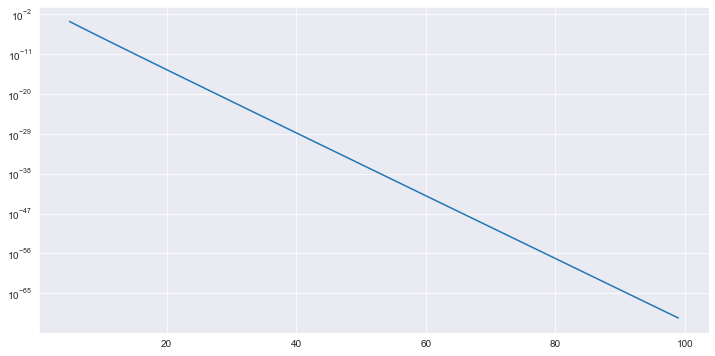

In [111]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_Hs = np.arange(5, 100)
ys = [0.5 * s.beta(d_H/2, 9*d_H/2) for d_H in d_Hs]
figsize = (12, 6)
plt.figure(figsize=figsize)
plt.plot(d_Hs, ys)
plt.yscale('log')
plt.show()

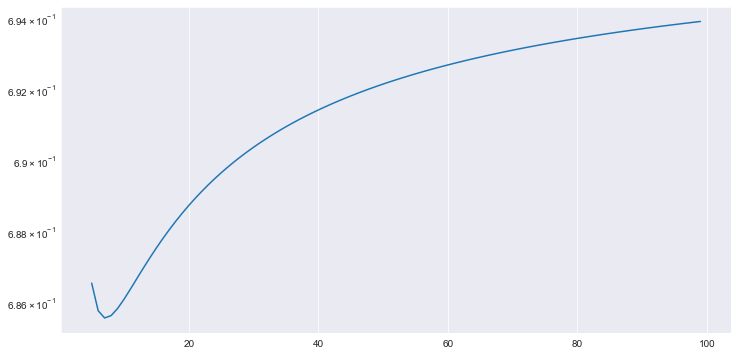

In [114]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_Hs = np.arange(5, 100)
scale = 10
ys = [(0.5 * s.beta(d_H/2, (scale -1) * d_H/2)) ** (2/((scale - 1) * d_H - 1)) for d_H in d_Hs]
figsize = (12, 6)
plt.figure(figsize=figsize)
plt.plot(d_Hs, ys)
plt.yscale('log')
plt.show()

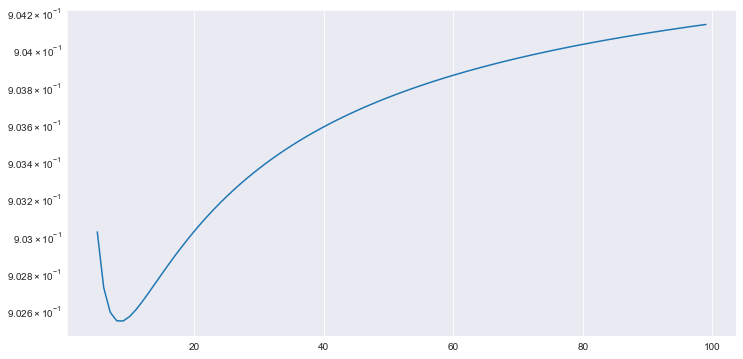

In [115]:
deltas = [0.001, 0.01, 0.1, 0.5]
d_Hs = np.arange(5, 100)
scale = 50
ys = [(0.5 * s.beta(d_H/2, (scale -1) * d_H/2)) ** (2/((scale - 1) * d_H - 1)) for d_H in d_Hs]
figsize = (12, 6)
plt.figure(figsize=figsize)
plt.plot(d_Hs, ys)
plt.yscale('log')
plt.show()

In [102]:
ys[1][291]

0.6406188140116794

In [103]:
np.arccos(0.6406188140116794)

0.8754924365159302

In [105]:
0.8754924365159302 / (np.pi/2)

0.5573557956443107

In [79]:
(1.5707963267948966 - 1.2197695534003814) / 1.219769553400381

0.2877812226218874

In [80]:
np.pi/4 / (np.pi/2)

0.5

In [72]:
np.sqrt(2) / 2

0.7071067811865476

In [58]:
np.arccos(0.3)

1.266103672779499

In [62]:
2*np.pi/5

1.2566370614359172

In [42]:
S(d_H) / (np.pi * S(d_H-1))

0.4244131815783876

In [43]:
[S(d_H) / (np.pi * S(d_H-1)) for d_H in np.arange(3, 40)]

[0.6366197723675815,
 0.4999999999999999,
 0.4244131815783876,
 0.375,
 0.33953054526271004,
 0.31250000000000006,
 0.29102618165375144,
 0.2734375,
 0.25868993924777905,
 0.24609375000000006,
 0.23517267204343556,
 0.22558593749999997,
 0.2170824665016328,
 0.20947265624999997,
 0.2026103020681906,
 0.196380615234375,
 0.19069204900535588,
 0.1854705810546875,
 0.18065562537349505,
 0.17619705200195315,
 0.17205297654618573,
 0.16818809509277347,
 0.16457241234852552,
 0.1611802577972412,
 0.15798951585458446,
 0.15498101711273196,
 0.15213805230441466,
 0.14944598078727725,
 0.14689191256977968,
 0.14446444809436795,
 0.14215346377720614,
 0.139949934091419,
 0.13784578305668474,
 0.13583375955931842,
 0.1339073321122081,
 0.1320605995715596,
 0.1302882150280943]

## 1D plots

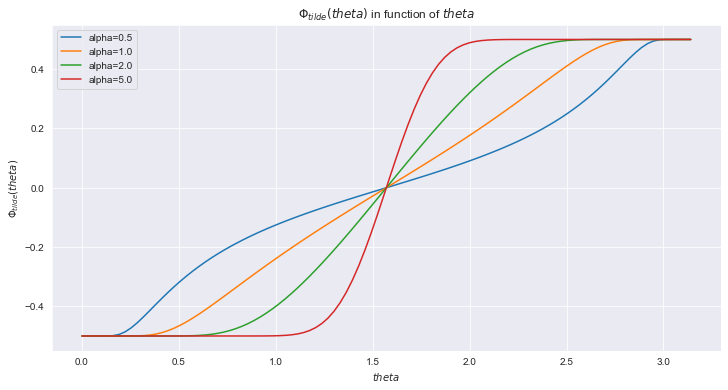

In [97]:
alphas = [0.5, 1.0, 2.0, 5.0]
start = 1e-3
stop = np.pi - 1e-3
num = 100

thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [phi_tilde(alpha, thetas) for alpha in alphas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,alpha in enumerate(alphas):
    plt.plot(thetas, ys[i], label='alpha={:.1f}'.format(alpha))

plt.title('$\Phi_{tilde}(theta)$ in function of $theta$')
plt.xlabel('$theta$')
plt.ylabel('$\Phi_{tilde}(theta)$')
plt.legend()
plt.show()

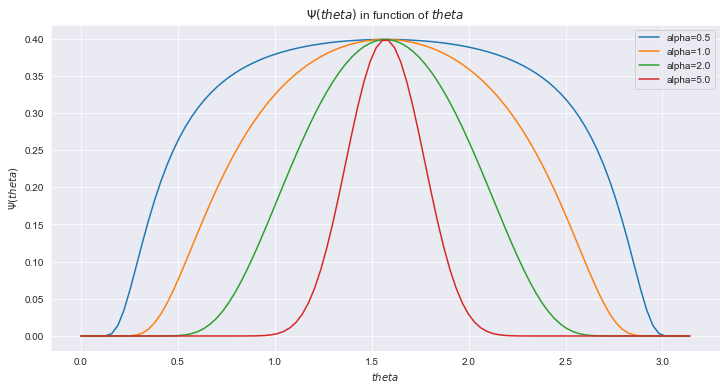

In [98]:
alphas = [0.5, 1.0, 2.0, 5.0]
start = 1e-3
stop = np.pi - 1e-3
num = 100

thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [psi(alpha, thetas) for alpha in alphas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,alpha in enumerate(alphas):
    plt.plot(thetas, ys[i], label='alpha={:.1f}'.format(alpha))

plt.title('$\Psi(theta)$ in function of $theta$')
plt.xlabel('$theta$')
plt.ylabel('$\Psi(theta)$')
plt.legend()
plt.show()

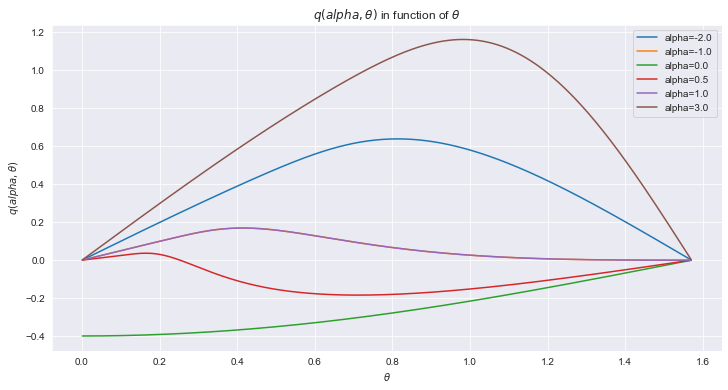

In [25]:
alphas = [-2.0, -1.0, 0., 0.5, 1.0, 3.0]
start = 1e-3
stop = np.pi/2 - 1e-3
num = 500

thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [q(alpha, thetas) for alpha in alphas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,alpha in enumerate(alphas):
    plt.plot(thetas, ys[i], label='alpha={:.1f}'.format(alpha))
a
plt.title('$q(alpha, \\theta)$ in function of $\\theta$')
plt.xlabel('$\\theta$')
plt.ylabel('$q(alpha, \\theta)$')
plt.legend()
plt.show()

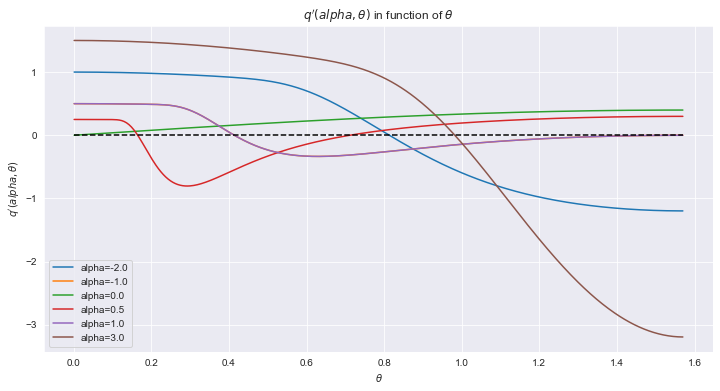

In [99]:
def q_prime(alpha, theta):
    return alpha * np.cos(theta) * phi_tilde(alpha, theta) + \
           (1 / (np.sin(theta) ** 3)) * psi(alpha, theta) * (np.sin(theta)**4 - alpha**2)

alphas = [-2.0, -1.0, 0., 0.5, 1.0, 3.0]
start = 1e-3
stop = np.pi/2 - 1e-3
num = 500

thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [q_prime(alpha, thetas) for alpha in alphas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,alpha in enumerate(alphas):
    plt.plot(thetas, ys[i], label='alpha={:.1f}'.format(alpha))
plt.plot(thetas, np.zeros_like(thetas), linestyle='dashed', color='k')
plt.title("$q'(alpha, \\theta)$ in function of $\\theta$")
plt.xlabel('$\\theta$')
plt.ylabel("$q'(alpha, \\theta)$")
plt.legend()
plt.show()

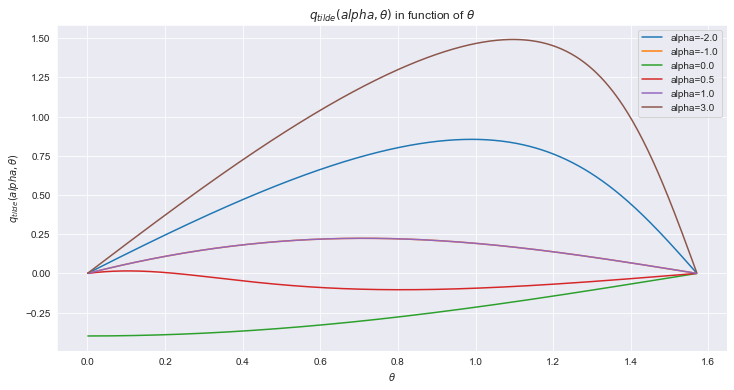

In [94]:
alphas = [-2.0, -1.0, 0., 0.5, 1.0, 3.0]
start = 1e-3
stop = np.pi/2 - 1e-3
num = 500

thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [[q_tilde(alpha, theta) for theta in thetas] for alpha in alphas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,alpha in enumerate(alphas):
    plt.plot(thetas, ys[i], label='alpha={:.1f}'.format(alpha))

plt.title('$q_{tilde}(alpha, \\theta)$ in function of $\\theta$')
plt.xlabel('$\\theta$')
plt.ylabel('$q_{tilde}(alpha, \\theta)$')
plt.legend()
plt.show()

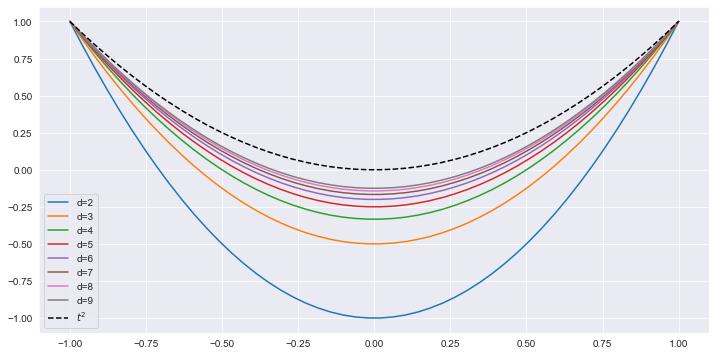

In [74]:
figsize = (12, 6)
dims = np.arange(2, 10)
ts = np.linspace(start=-1, stop=1, endpoint=True, num=50)
ys = [[(dim * (t ** 2) - 1) / (dim - 1) for t in ts] for dim in dims]
plt.figure(figsize=figsize)
for i, dim in enumerate(dims):
    plt.plot(ts, ys[i], label='d={}'.format(dim))
plt.plot(ts, ts ** 2, linestyle='dashed', color='k', label='$t^2$')
plt.legend()
plt.show()

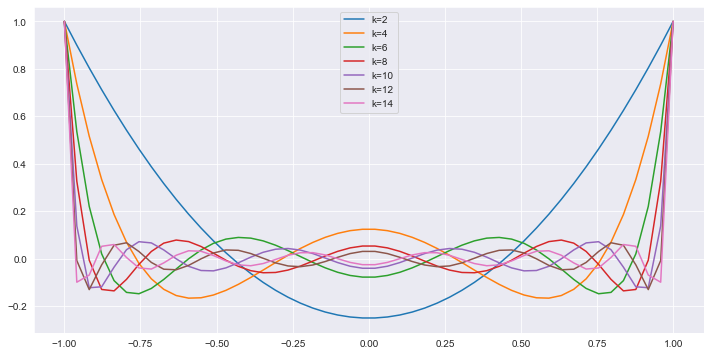

In [88]:
figsize = (12, 6)
ks = np.arange(1, 8)
dim = 5
ts = np.linspace(start=-1, stop=1, endpoint=True, num=50)
ys = [[legendre(2*k, dim, t) for t in ts] for k in ks]
plt.figure(figsize=figsize)
for i, k in enumerate(ks):
    plt.plot(ts, ys[i], label='k={}'.format(2*k))
plt.legend()
plt.show()

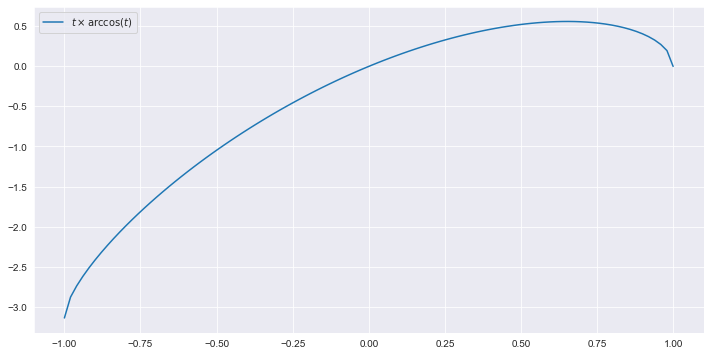

In [205]:
figsize = (12, 6)
ks = np.arange(1, 8)
dim = 5
ts = np.linspace(start=-1, stop=1, endpoint=True, num=100)
ys = [t * np.arccos(t) for t in ts]
plt.figure(figsize=figsize)
plt.plot(ts, ys, label='$t \\times \\arccos(t)$')
plt.legend()
plt.show()

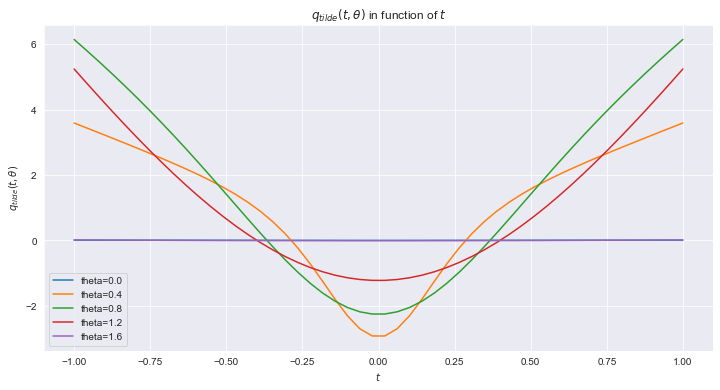

In [89]:
ts = np.linspace(-1, 1, endpoint=True, num=50)
dim = 5

thetas = np.linspace(start=1e-3, stop=np.pi/2-1e-3, endpoint=True, num=5)
ys = [[q_tilde(t, theta, d_H=dim) for t in ts] for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={:.1f}'.format(theta))

plt.title('$q_{tilde}(t, \\theta)$ in function of $t$')
plt.xlabel('$t$')
plt.ylabel('$q_{tilde}(t, \\theta)$')
plt.legend()
plt.show()

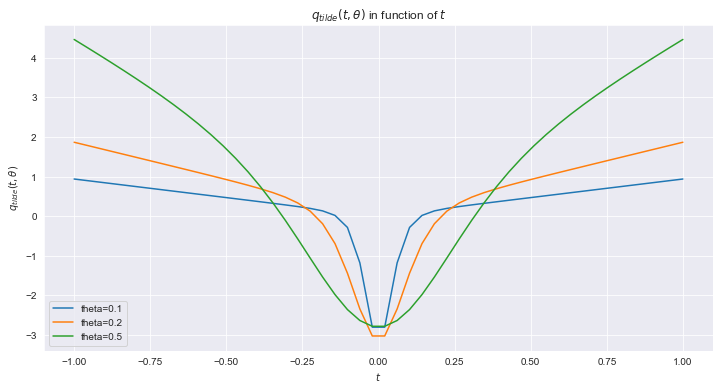

In [92]:
ts = np.linspace(-1, 1, endpoint=True, num=50)
dim = 5

thetas = [0.1, 0.2, 0.5]
ys = [[q_tilde(t, theta, d_H=dim) for t in ts] for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={:.1f}'.format(theta))

plt.title('$q_{tilde}(t, \\theta)$ in function of $t$')
plt.xlabel('$t$')
plt.ylabel('$q_{tilde}(t, \\theta)$')
plt.legend()
plt.show()

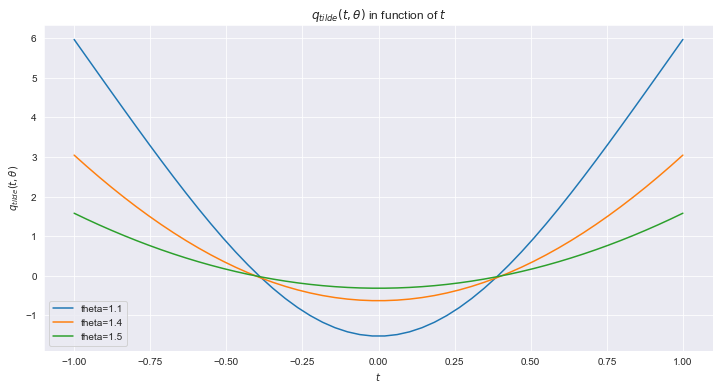

In [93]:
ts = np.linspace(-1, 1, endpoint=True, num=50)
dim = 5

thetas = [np.pi/2 - 0.5, np.pi/2 - 0.2, np.pi/2 - 0.1]
ys = [[q_tilde(t, theta, d_H=dim) for t in ts] for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={:.1f}'.format(theta))

plt.title('$q_{tilde}(t, \\theta)$ in function of $t$')
plt.xlabel('$t$')
plt.ylabel('$q_{tilde}(t, \\theta)$')
plt.legend()
plt.show()

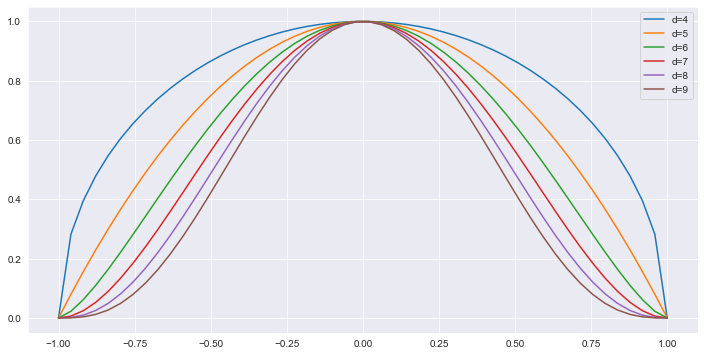

In [76]:
figsize = (12, 6)
dims = np.arange(4, 10)
ts = np.linspace(start=-1, stop=1, endpoint=True, num=50)
ys = [[(1 -(t ** 2))**((dim - 3)/2) for t in ts] for dim in dims]
plt.figure(figsize=figsize)
for i, dim in enumerate(dims):
    plt.plot(ts, ys[i], label='d={}'.format(dim))
#plt.plot(ts, ts ** 2, linestyle='dashed', color='k', label='$t^2$')
plt.legend()
plt.show()

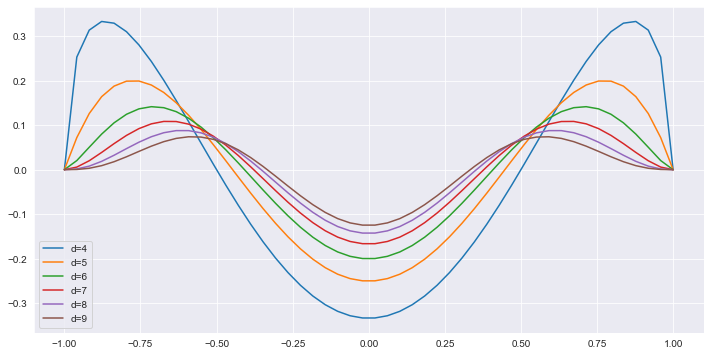

In [84]:
figsize = (12, 6)
dims = np.arange(4, 10)
ts = np.linspace(start=-1, stop=1, endpoint=True, num=50)
ys = [[(1 -(t ** 2))**((dim - 3)/2) * (dim * (t ** 2) - 1) / (dim - 1) for t in ts] for dim in dims]
plt.figure(figsize=figsize)
for i, dim in enumerate(dims):
    plt.plot(ts, ys[i], label='d={}'.format(dim))
#plt.plot(ts, ts ** 2, linestyle='dashed', color='k', label='$t^2$')
plt.legend()
plt.show()

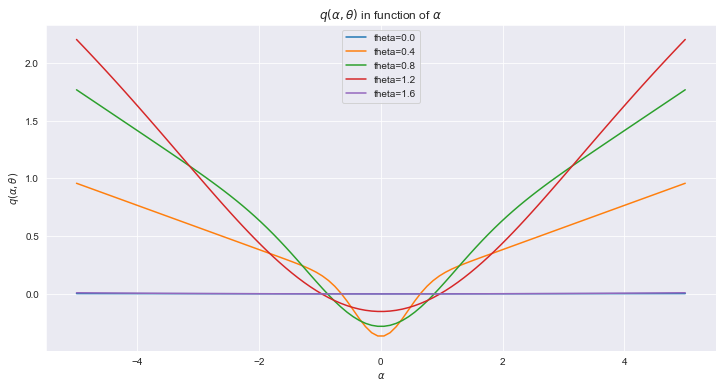

In [78]:
alphas = np.linspace(-5, 5, endpoint=True, num=100)


thetas = np.linspace(start=1e-3, stop=np.pi/2-1e-3, endpoint=True, num=5)
ys = [q(alphas, theta) for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={:.1f}'.format(theta))

plt.title('$q(\\alpha, \\theta)$ in function of $\\alpha$')
plt.xlabel('$\\alpha$')
plt.ylabel('$q(\\alpha, \\theta)$')
plt.legend()
plt.show()

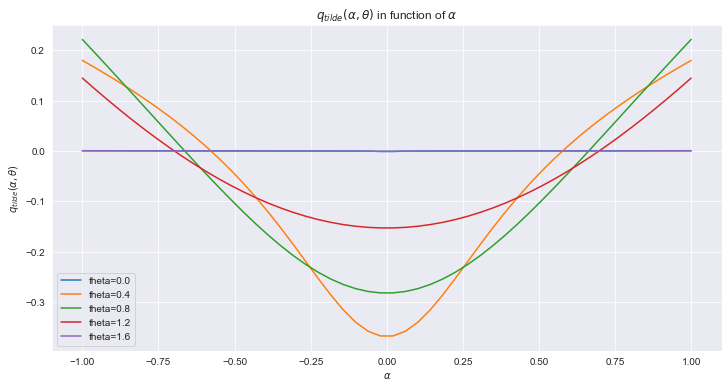

In [81]:
alphas = np.linspace(-1, 1, endpoint=True, num=50)


thetas = np.linspace(start=1e-3, stop=np.pi/2-1e-3, endpoint=True, num=5)
ys = [[q_tilde(alpha, theta) for alpha in alphas] for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={:.1f}'.format(theta))

plt.title('$q_{tilde}(\\alpha, \\theta)$ in function of $\\alpha$')
plt.xlabel('$\\alpha$')
plt.ylabel('$q_{tilde}(\\alpha, \\theta)$')
plt.legend()
plt.show()

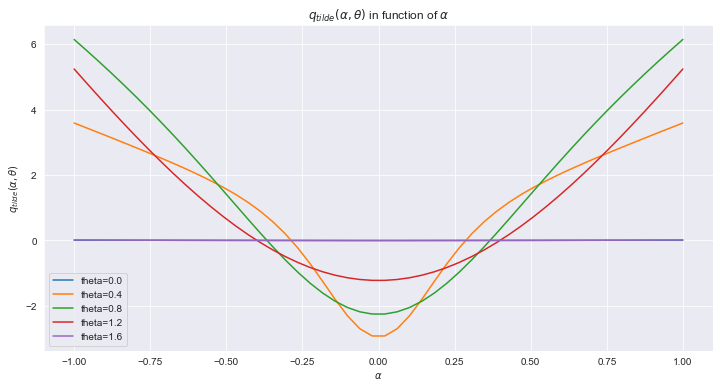

In [82]:
alphas = np.linspace(-1, 1, endpoint=True, num=50)


thetas = np.linspace(start=1e-3, stop=np.pi/2-1e-3, endpoint=True, num=5)
ys = [[q_tilde(alpha, theta, d_H=5) for alpha in alphas] for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={:.1f}'.format(theta))

plt.title('$q_{tilde}(\\alpha, \\theta)$ in function of $\\alpha$')
plt.xlabel('$\\alpha$')
plt.ylabel('$q_{tilde}(\\alpha, \\theta)$')
plt.legend()
plt.show()

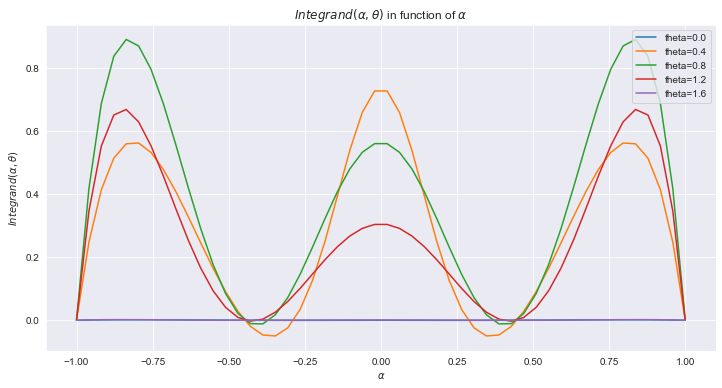

In [83]:
ts = np.linspace(-1, 1, endpoint=True, num=50)
dim = 5

thetas = np.linspace(start=1e-3, stop=np.pi/2-1e-3, endpoint=True, num=5)
ys = [[q_tilde(t, theta, d_H=dim) * \
       (1 -(t ** 2))**((dim - 3)/2) * \
       (dim * (t ** 2) - 1) / (dim - 1)
       for t in ts] for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={:.1f}'.format(theta))

plt.title('$Integrand(\\alpha, \\theta)$ in function of $\\alpha$')
plt.xlabel('$\\alpha$')
plt.ylabel('$Integrand(\\alpha, \\theta)$')
plt.legend()
plt.show()

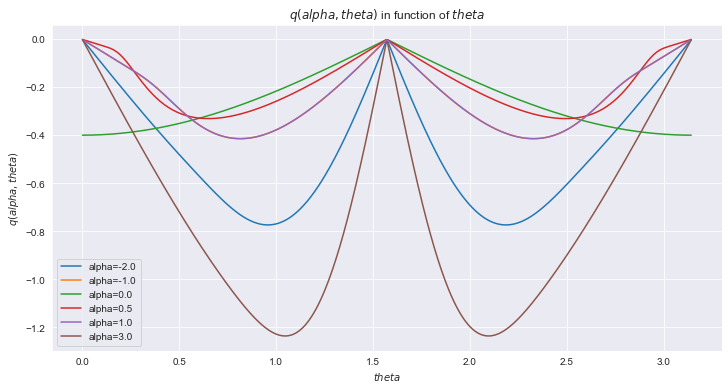

In [99]:
alphas = [-2.0, -1.0, 0., 0.5, 1.0, 3.0]
start = 1e-3
stop = np.pi - 1e-3
num = 500

thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [q(alpha, thetas) for alpha in alphas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i,alpha in enumerate(alphas):
    plt.plot(thetas, ys[i], label='alpha={:.1f}'.format(alpha))

plt.title('$q(alpha, theta)$ in function of $theta$')
plt.xlabel('$theta$')
plt.ylabel('$q(alpha, theta)$')
plt.legend()
plt.show()

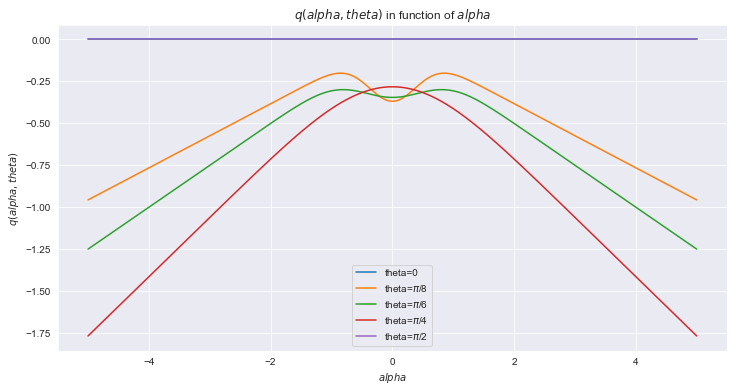

In [100]:
thetas = [1e-6, np.pi/8, np.pi/6, np.pi/4, np.pi/2]
label_thetas = ['0', '$\pi$/8', '$\pi$/6', '$\pi$/4', '$\pi$/2']
start = -5.0
stop = 5.0
num = 500

alphas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [q(alphas, thetas[0], sign=False)] + [q(alphas, theta) for theta in thetas[1:]]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={}'.format(label_thetas[i]))

plt.title('$q(alpha, theta)$ in function of $alpha$')
plt.xlabel('$alpha$')
plt.ylabel('$q(alpha, theta)$')
plt.legend()
plt.show()

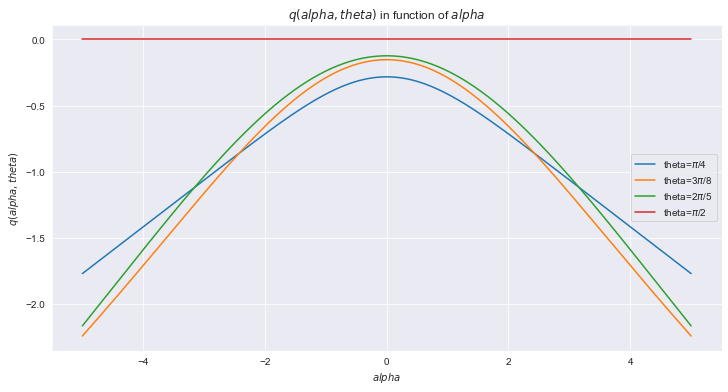

In [101]:
thetas = [np.pi/4, 3*np.pi/8, 2*np.pi/5, np.pi/2]
label_thetas = ['$\pi$/4', '3$\pi$/8', '2$\pi$/5', '$\pi$/2']
start = -5.0
stop = 5.0
num = 500

alphas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [q(alphas, theta) for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={}'.format(label_thetas[i]))

plt.title('$q(alpha, theta)$ in function of $alpha$')
plt.xlabel('$alpha$')
plt.ylabel('$q(alpha, theta)$')
plt.legend()
plt.show()

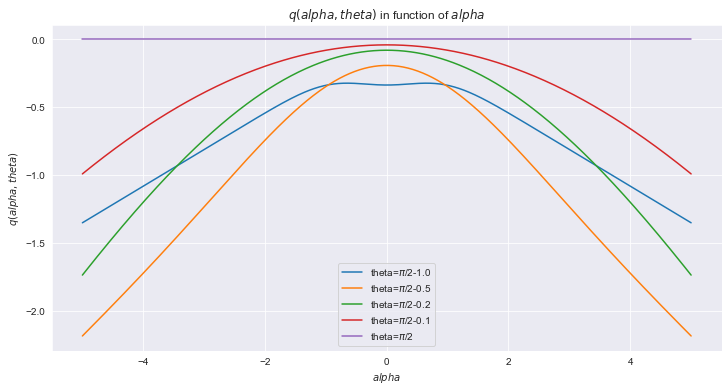

In [104]:
thetas = [np.pi/2 - 1.0, np.pi/2 - 0.5, np.pi/2 - 0.2, np.pi/2 - 0.1, np.pi/2]
label_thetas = ['$\pi$/2-1.0', '$\pi$/2-0.5', '$\pi$/2-0.2', '$\pi$/2-0.1', '$\pi$/2']
start = -5.0
stop = 5.0
num = 500

alphas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [q(alphas, theta) for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={}'.format(label_thetas[i]))

plt.title('$q(alpha, theta)$ in function of $alpha$')
plt.xlabel('$alpha$')
plt.ylabel('$q(alpha, theta)$')
plt.legend()
plt.show()

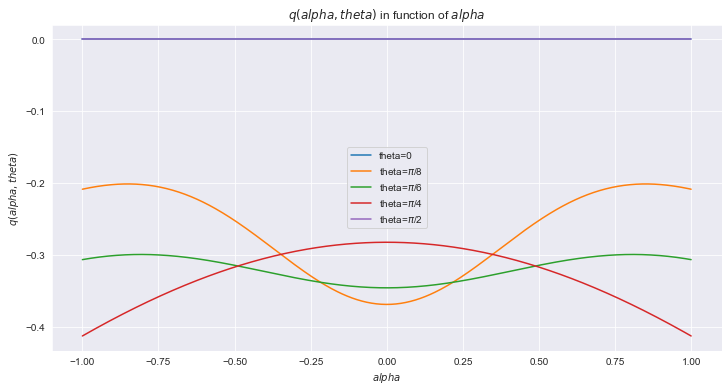

In [114]:
thetas = [1e-6, np.pi/8, np.pi/6, np.pi/4, np.pi/2]
label_thetas = ['0', '$\pi$/8', '$\pi$/6', '$\pi$/4', '$\pi$/2']
start = -1.0
stop = 1.0
num = 500

alphas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [q(alphas, thetas[0], sign=False)] + [q(alphas, theta) for theta in thetas[1:]]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={}'.format(label_thetas[i]))

plt.title('$q(alpha, theta)$ in function of $alpha$')
plt.xlabel('$alpha$')
plt.ylabel('$q(alpha, theta)$')
plt.legend()
plt.show()

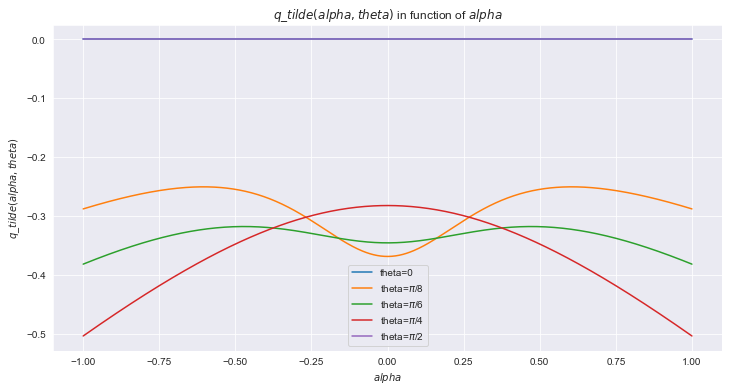

In [117]:
thetas = [1e-6, np.pi/8, np.pi/6, np.pi/4, np.pi/2]
label_thetas = ['0', '$\pi$/8', '$\pi$/6', '$\pi$/4', '$\pi$/2']
start = -1.0
stop = 1.0
num = 500

alphas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [[q_tilde(alpha, theta) for alpha in alphas] for theta in thetas]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, theta in enumerate(thetas):
    plt.plot(alphas, ys[i], label='theta={}'.format(label_thetas[i]))

plt.title('$q\_tilde(alpha, theta)$ in function of $alpha$')
plt.xlabel('$alpha$')
plt.ylabel('$q\_tilde(alpha, theta)$')
plt.legend()
plt.show()

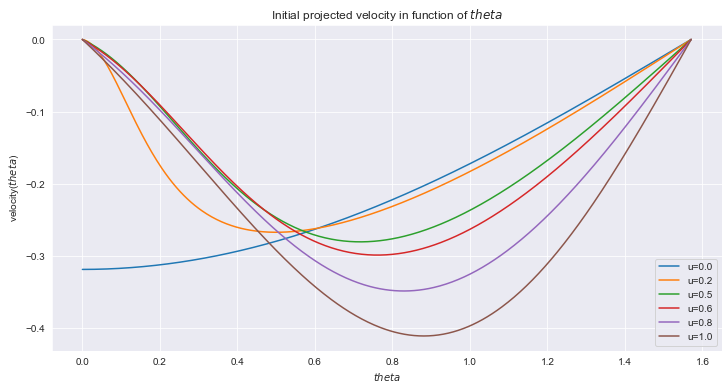

In [139]:
us = [0., 0.2, 0.5, 0.6, 0.8, 1.0]
start = 1e-6
stop = np.pi/2
num = 500

f_H = lambda x_H: np.abs(x_H)
thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [[velocity_1d(theta, u, f_H) for theta in thetas] for u in us]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, u in enumerate(us):
    plt.plot(thetas, ys[i], label='u={}'.format(u))

plt.title('Initial projected velocity in function of $theta$')
plt.xlabel('$theta$')
plt.ylabel('velocity($theta$)')
plt.legend()
plt.show()

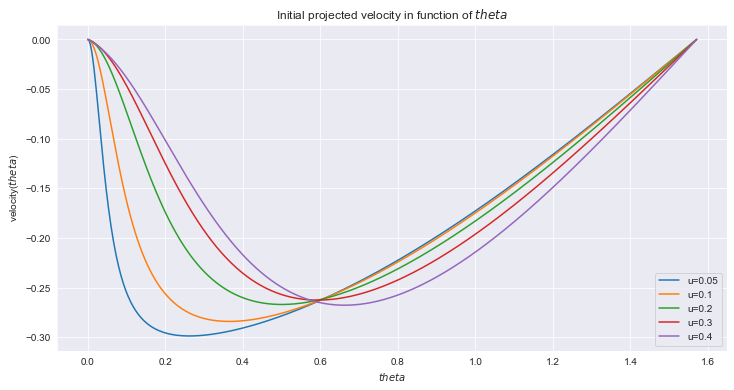

In [141]:
us = [0.05, 0.1, 0.2, 0.3, 0.4]
start = 1e-6
stop = np.pi/2
num = 500

f_H = lambda x_H: np.abs(x_H)
thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [[velocity_1d(theta, u, f_H) for theta in thetas] for u in us]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, u in enumerate(us):
    plt.plot(thetas, ys[i], label='u={}'.format(u))

plt.title('Initial projected velocity in function of $theta$')
plt.xlabel('$theta$')
plt.ylabel('velocity($theta$)')
plt.legend()
plt.show()

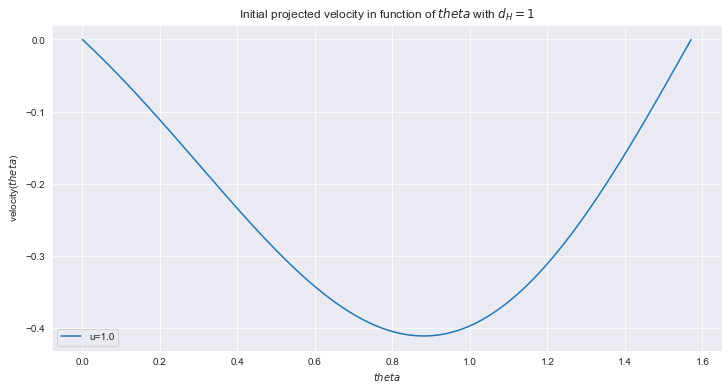

In [173]:
us = [1.0]
start = 1e-6
stop = np.pi/2
num = 500

f_H = lambda x_H: np.abs(x_H)
thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [[velocity_1d(theta, u, f_H) for theta in thetas] for u in us]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, u in enumerate(us):
    plt.plot(thetas, ys[i], label='u={}'.format(u))

plt.title('Initial projected velocity in function of $theta$ with $d_H = 1$')
plt.xlabel('$theta$')
plt.ylabel('velocity($theta$)')
plt.legend()
plt.show()

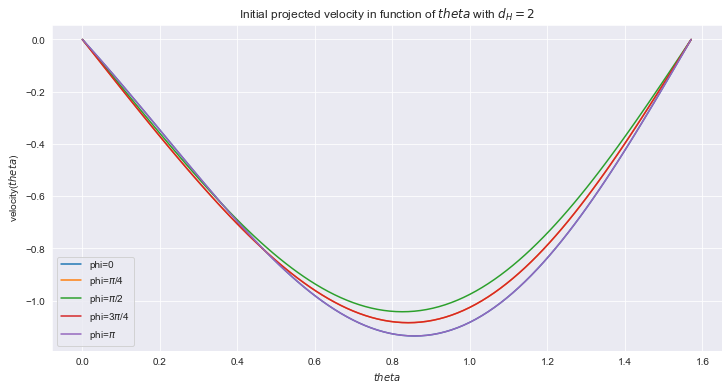

In [174]:
phis = [0., np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
label_phis = ['0', '$\pi$/4', '$\pi$/2', '3$\pi$/4', '$\pi$']
start = 1e-6
stop = np.pi/2
num = 100
a = 2
b = 1

f_H = lambda x,y: a * np.abs(x) + b * np.abs(y)
thetas = np.linspace(start=start, stop=stop, endpoint=True, num=num)
ys = [[velocity_2d(theta, phi, f_H) for theta in thetas] for phi in phis]

figsize = (12, 6)
plt.figure(figsize=figsize)
for i, phi in enumerate(phis):
    plt.plot(thetas, ys[i], label='phi={}'.format(label_phis[i]))

plt.title('Initial projected velocity in function of $theta$ with $d_H = 2$')
plt.xlabel('$theta$')
plt.ylabel('velocity($theta$)')
plt.legend()
plt.show()

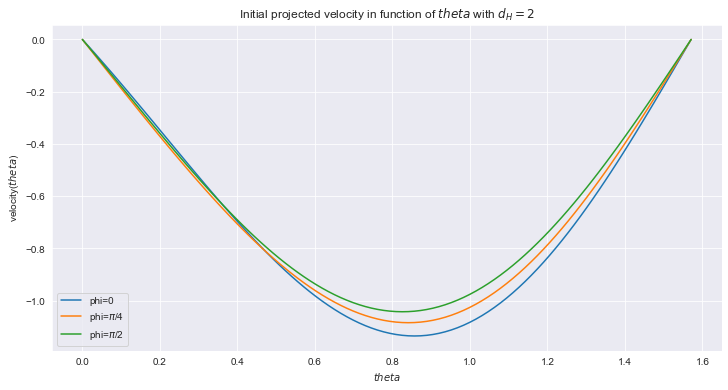

In [176]:
figsize = (12, 6)
plt.figure(figsize=figsize)
for i, phi in enumerate(phis[:3]):
    plt.plot(thetas, ys[i], label='phi={}'.format(label_phis[i]))

plt.title('Initial projected velocity in function of $theta$ with $d_H = 2$')
plt.xlabel('$theta$')
plt.ylabel('velocity($theta$)')
plt.legend()
plt.show()

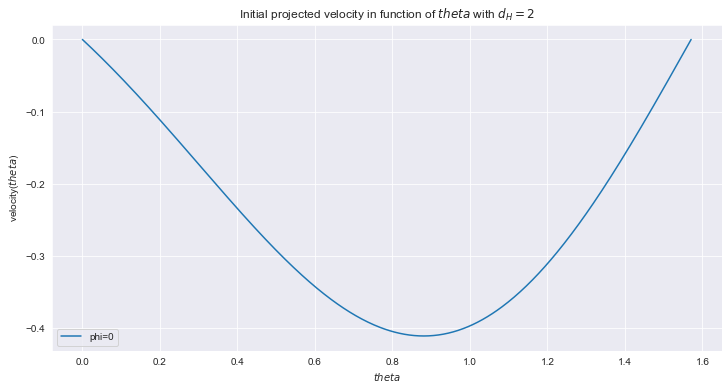

In [171]:
figsize = (12, 6)
plt.figure(figsize=figsize)
plt.plot(thetas, ys[0], label='phi={}'.format(0))

plt.title('Initial projected velocity in function of $theta$ with $d_H = 2$')
plt.xlabel('$theta$')
plt.ylabel('velocity($theta$)')
plt.legend()
plt.show()

## 2D plots

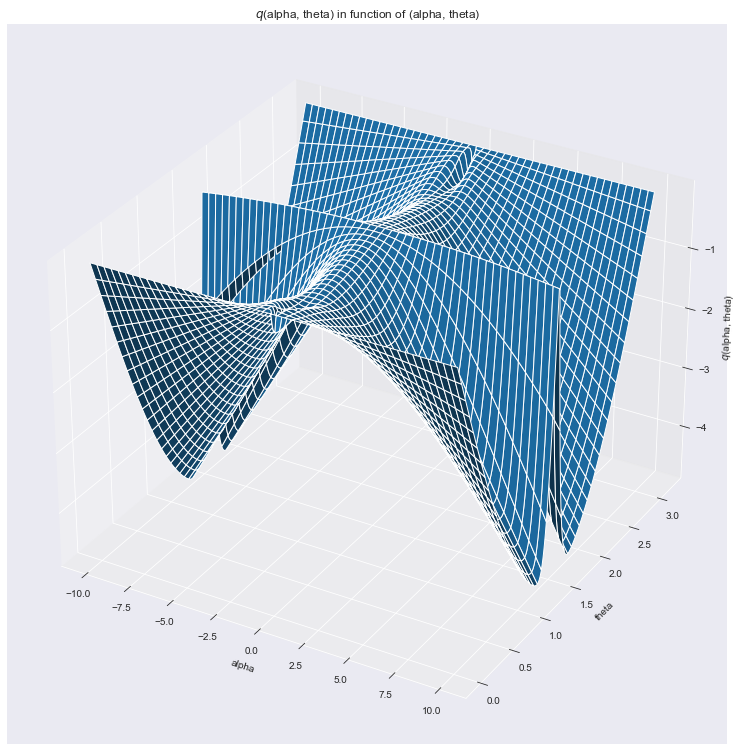

In [103]:
alphas = [0.5, 1.0, 2.0, 5.0]

start_alpha = -10.0
stop_alpha = 10.0

start_theta = 1e-3
stop_theta = np.pi - 1e-3
num = 300

alphas = np.linspace(start=start_alpha, stop=stop_alpha, endpoint=True, num=num)
thetas = np.linspace(start=start_theta, stop=stop_theta, endpoint=True, num=num)

X, Y = np.meshgrid(alphas, thetas)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(Y.shape[1]):
        Z[i,j] = q(X[i,j], Y[i,j])

figsize = (10, 10)
fig = plt.figure(figsize=figsize)
ax = Axes3D(fig, auto_add_to_figure=False)
ax.plot_surface(X, Y, Z)
fig.add_axes(ax)

plt.title('$q$(alpha, theta) in function of (alpha, theta)')

ax.set_xlabel('alpha')
ax.set_ylabel('theta')
ax.set_zlabel('$q$(alpha, theta)')
plt.show()

## Volumes of the unit ball and shere

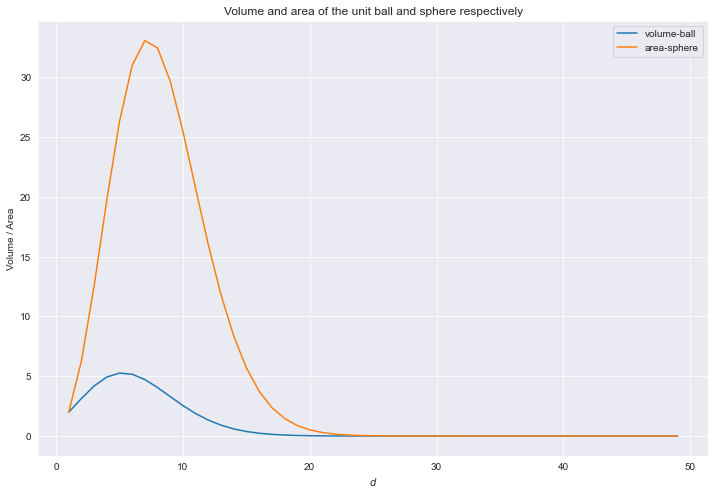

In [19]:
ds = np.arange(1, 50)
volumes = [(np.pi ** (d/2)) / scipy.special.gamma(d/2 + 1) for d in ds]
areas = [2 * (np.pi ** (d/2)) / scipy.special.gamma(d/2) for d in ds]
plt.figure(figsize=(12, 8))
plt.plot(ds, volumes, label='volume-ball')
plt.plot(ds, areas, label='area-sphere')

plt.legend()
plt.title('Volume and area of the unit ball and sphere respectively')
plt.xlabel('$d$')
plt.ylabel('Volume / Area')
plt.show()